In [2]:
from IPython.display import Audio
from scipy.io import wavfile
import librosa

import tensorflow.compat.v1 as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
from matplotlib import cm

### Load the dataset

In [14]:
## Building the data tensor set
## Using 3400 audios for each classes
## for counting number of data in the dataset through file system;
## Reference method: image_count = len(list(DATASETPATH.glob('./*.wav')))
## Padding the data with zeros to length 15872
data_tensor_yes = []
data_tensor_no = []
data_tensor_test_yes = []
data_tensor_test_no = []
for i in range(3400):
    filename = './Dataset/yes/yes' + str(i+1) + '.wav'
    data_rate, data_audio_tensor = wavfile.read(filename)
    if len(data_audio_tensor)>15872:
        data_audio_tensor = data_audio_tensor[:15872]
    else:
        for j in range(15872-len(data_audio_tensor)):
            data_audio_tensor = np.append(data_audio_tensor,[0])
    data_tensor_yes.append(data_audio_tensor)
    
for i in range(3400):
    filename = './Dataset/no/no' + str(i+1) + '.wav'
    data_rate, data_audio_tensor = wavfile.read(filename)
    if len(data_audio_tensor)>15872:
        data_audio_tensor = data_audio_tensor[:15872]
    else:
        for j in range(15872-len(data_audio_tensor)):
            data_audio_tensor = np.append(data_audio_tensor,[0])
    data_tensor_no.append(data_audio_tensor)
    
## load test dataset
for i in range(490):
    filename = './test_set/yes/yes' + str(i+1) + '.wav'
    data_rate, data_audio_tensor = wavfile.read(filename)
    if len(data_audio_tensor)>15872:
        data_audio_tensor = data_audio_tensor[:15872]
    else:
        for j in range(15872-len(data_audio_tensor)):
            data_audio_tensor = np.append(data_audio_tensor,[0])
    data_tensor_test_yes.append(data_audio_tensor)
    
for i in range(490):
    filename = './test_set/no/no' + str(i+1) + '.wav'
    data_rate, data_audio_tensor = wavfile.read(filename)
    if len(data_audio_tensor)>=15872:
        data_audio_tensor = data_audio_tensor[:15872]
    else:
        for j in range(15872-len(data_audio_tensor)):
            data_audio_tensor = np.append(data_audio_tensor,[0])
    data_tensor_test_no.append(data_audio_tensor)
##print(data_tensor_yes[0])
print("load done")

load done


## Data pre-process by the librosa

In [33]:
## Construct the mfcc set
'''
mfcc_set_yes = []
mfcc_set_no = []

mfcc_test_set_yes = []
mfcc_test_set_no = []

mfcc_train_labels = []
mfcc_test_labels = []
for i in data_tensor_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(i),
                                                               sr=16000,
                                                               n_fft=512,
                                                               hop_length=256,
                                                               n_mels=40))
    mfcc_set_yes.append(mfcc_audio)
    mfcc_train_labels.append(1)
    
for i in data_tensor_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(i),
                                                               sr=16000,
                                                               n_fft=512,
                                                               hop_length=256,
                                                               n_mels=40))
    mfcc_set_no.append(mfcc_audio)
    mfcc_train_labels.append(0)


## load test mfccs
for i in data_tensor_test_yes:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(i),
                                                               sr=16000,
                                                               n_fft=512,
                                                               hop_length=256,
                                                               n_mels=40))
    mfcc_test_set_yes.append(mfcc_audio)
    mfcc_test_labels.append(1)

for i in data_tensor_test_no:
    mfcc_audio = librosa.power_to_db(librosa.feature.melspectrogram(y=np.float32(i),
                                                               sr=16000,
                                                               n_fft=512,
                                                               hop_length=256,
                                                               n_mels=40))
    mfcc_test_set_no.append(mfcc_audio)
    mfcc_test_labels.append(0)
'''

## Mel_spectrogram generating

In [20]:
## Define the functions
import sys

def hamming(length):
    weight = []
    for i in range(length):
        weight.append(0.56-0.46*np.cos((2.*np.pi*float(i))/(float(length)-1.)))
    max_x = np.max(weight)
    min_x = np.min(weight)
    for i in range(length):
        weight[i] = (weight[i]-min_x)/(max_x - min_x)
    return weight

def stft(data, num_of_inputs, window_size, hop_length):
    num_of_ffts = (num_of_inputs - window_size)/hop_length
    n_fft = (window_size/2)+1
    fft_arr = []
    counter = 0
    pointer = 0
    while(counter != num_of_ffts):
        window = data[pointer:(pointer+window_size)]
        weight = hamming(window_size)
        fft_ = np.fft.fft(window*weight)
        fft_arr.append(np.abs(fft_[:int(n_fft)]))
        pointer+=hop_length
        counter+=1
    return fft_arr

def mel_spec(data, num_of_inputs, window_size, hop_length, n_mels, sample_rate):
    num_of_ffts = (num_of_inputs - window_size)/hop_length
    n_ffts = (window_size/2)+1

    lower_freq = 300
    upper_freq = 8000

    mel_lower_freq = 1125*np.log(1+lower_freq/700)
    mel_upper_freq = 1125*np.log(1+upper_freq/700)
    mel_gap = (mel_upper_freq - mel_lower_freq)/(n_mels+1)

    ## Define the filterbank
    mel_value = mel_lower_freq
    fbin = []
    counter = 0
    while(counter<n_mels+2):
        mel_to_hz = 700*(np.exp(mel_value/1125)-1)

        rounding_freq = np.floor((n_ffts*mel_to_hz)/sample_rate)
        fbin.append(rounding_freq)
        mel_value+=mel_gap

        counter+=1

    filterbank = np.zeros((n_mels, int(n_ffts)))
    for m in range(1, n_mels+1):
        f_min = int(fbin[m-1])
        f_mid = int(fbin[m])
        f_max = int(fbin[m+1])

        for k in range(f_min, f_mid):
            filterbank[m-1, k] = (k - fbin[m-1])/(fbin[m] - fbin[m-1])
        for k in range(f_mid, f_max):
            filterbank[m-1, k] = (fbin[m+1] - k)/(fbin[m+1] - fbin[m])
    
    stft_arr = stft(data, num_of_inputs, window_size, hop_length)
    mel_spec_arr = np.dot(np.array(stft_arr), filterbank.T)
    

    return mel_spec_arr

def amplitude_to_db(mel_spec_arr):
    ref_value = np.max(mel_spec_arr)
    mel_spec_arr = np.square(mel_spec_arr)
    ref_value = ref_value**2
    mel_spec_arr_db = 10*np.log10(np.maximum(sys.float_info.min, mel_spec_arr))
    mel_spec_arr_db -= 10*np.log10(np.maximum(sys.float_info.min, ref_value))
    mel_spec_arr_db = np.maximum(mel_spec_arr_db, mel_spec_arr_db.max()-80)

    return mel_spec_arr_db

(60, 40)
[[-80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -78.97969468 -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -78.64563495 -80.         -74.1480606  -70.36661866 -67.5225434
  -75.67403686 -77.29147045 -74.19117969 -80.         -79.13420895]
 [-80.         -80.         -79.48334978 -80.         -80.
  -80.         -80.         -79.87234044 -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -80.
  -80.         -80.         -80.         -80.         -76.37778465
  -79.01255835 -79.42314436 -71.10043184 -70.95889082 -61.07290572
  -56.25906793 -45.21187992 -37.37273998 -50.16971052 -64.16402019]
 [-80.

(0.0, 11000.0)

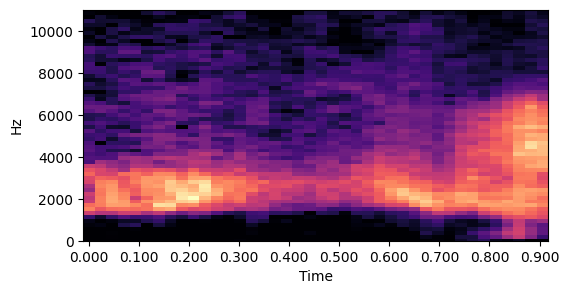

In [21]:
## testing the results
mel_spec_arr = mel_spec(data_tensor_yes[0], 15872, 512, 256, 40, 16000)
mel_spec_db = amplitude_to_db(mel_spec_arr)
print(np.array(mel_spec_db).shape)
print(np.array(mel_spec_db))
fig, ax = plt.subplots(figsize=(6, 3))
librosa.display.specshow(
    mel_spec_db,
    y_axis="hz",
    x_axis="time",
    ax=ax,
    fmax=6000
)
plt.ylim([0, 11000])

In [22]:
## Processing the data to mel_spectrogram
import datetime

melSpec_set_yes = []
melSpec_set_no = []
melSpec_train_labels = []

window_size = 512
step = 256
num_of_inputs = 15872
sample_rate = 16000

count = 0
print("Loading 'yes': ", end="")
for i in data_tensor_yes:
    mel_spec_arr = mel_spec(i, num_of_inputs, window_size, step, 40, sample_rate)
    ref_value = np.max(mel_spec_arr )
    mel_spec_arr = np.square(mel_spec_arr)
    ref_value = ref_value**2
    mel_spec_db = 10*np.log10(np.maximum(sys.float_info.min, mel_spec_arr))
    mel_spec_db -= 10*np.log10(np.maximum(sys.float_info.min, ref_value))
    mel_spec_db = np.maximum(mel_spec_db, mel_spec_db.max()-80)

    melSpec_set_yes.append(mel_spec_db)
    melSpec_train_labels.append(1)
    count += 1
    if(count%340==0):
        print("#", end="")

print()
print("train set 'yes' finished")
print("Loading 'no': ", end="")
count = 0
for i in data_tensor_no:
    mel_spec_arr = mel_spec(i, num_of_inputs, window_size, step, 40, sample_rate)
    ref_value = np.max(mel_spec_arr )
    mel_spec_arr = np.square(mel_spec_arr)
    ref_value = ref_value**2
    mel_spec_db = 10*np.log10(np.maximum(sys.float_info.min, mel_spec_arr))
    mel_spec_db -= 10*np.log10(np.maximum(sys.float_info.min, ref_value))
    mel_spec_db = np.maximum(mel_spec_db, mel_spec_db.max()-80)

    melSpec_set_no.append(mel_spec_db)
    melSpec_train_labels.append(0)
    count += 1
    if(count%340==0):
        print("#", end="")
print()
print("train set 'no' finished")    
print(np.array(melSpec_set_yes).shape)
print(np.array(melSpec_set_no).shape)
## print the time finished
print(datetime.datetime.now())

Loading 'yes': ##########
train set 'yes' finished
Loading 'no': ##########
train set 'no' finished
(3400, 60, 40)
(3400, 60, 40)
2024-05-27 11:28:21.314588


In [23]:
window_size = 512
step = 256
num_of_inputs = 15872
sample_rate = 16000

melSpec_test_set_yes = []
melSpec_test_set_no = []
melSpec_test_labels = []

counter = 0
print("Loading 'yes': ", end="")
for i in data_tensor_test_yes:
    mel_spec_arr = mel_spec(i, num_of_inputs, window_size, step, 40, sample_rate)
    ref_value = np.max(mel_spec_arr )
    mel_spec_arr = np.square(mel_spec_arr)
    ref_value = ref_value**2
    mel_spec_db = 10*np.log10(np.maximum(sys.float_info.min, mel_spec_arr))
    mel_spec_db -= 10*np.log10(np.maximum(sys.float_info.min, ref_value))
    mel_spec_db = np.maximum(mel_spec_db, mel_spec_db.max()-80)
    
    melSpec_test_set_yes.append(mel_spec_db)
    melSpec_test_labels.append(1)
    count += 1
    if(count%49==0):
        print("#", end="")

print()
print("test set 'yes' finished")
print("Loading 'no': ", end="")
count = 0
for i in data_tensor_test_no:
    mel_spec_arr = mel_spec(i, num_of_inputs, window_size, step, 40, sample_rate)
    ref_value = np.max(mel_spec_arr )
    mel_spec_arr = np.square(mel_spec_arr)
    ref_value = ref_value**2
    mel_spec_db = 10*np.log10(np.maximum(sys.float_info.min, mel_spec_arr))
    mel_spec_db -= 10*np.log10(np.maximum(sys.float_info.min, ref_value))
    mel_spec_db = np.maximum(mel_spec_db, mel_spec_db.max()-80)
    
    melSpec_test_set_no.append(mel_spec_db)
    melSpec_test_labels.append(0)
    count += 1
    if(count%49==0):
        print("#", end="")

print()
print("train set 'no' finished") 
print(np.array(melSpec_test_set_yes).shape)
print(np.array(melSpec_test_set_no).shape)
## print the time finished
print(datetime.datetime.now())

Loading 'yes': ##########
test set 'yes' finished
Loading 'no': ##########
train set 'no' finished
(490, 60, 40)
(490, 60, 40)
2024-05-27 11:32:51.917257


## Flatten the data

In [50]:
train_ds = []
test_ds = []
print(melSpec_set_yes[0].shape)
##print(melSpec_set_yes[0])

## resize
for i in melSpec_set_yes:
    resized = np.resize(i, (60, 40))
    resized = resized.flatten()
    train_ds.append(resized)
for i in melSpec_set_no:
    resized = np.resize(i, (60, 40))
    resized = resized.flatten()
    train_ds.append(resized)

for i in melSpec_test_set_yes:
    resized = np.resize(i, (60, 40))
    resized = resized.flatten()
    test_ds.append(resized)
for i in melSpec_test_set_no:
    resized = np.resize(i, (60, 40))
    resized = resized.flatten()
    test_ds.append(resized)

train_ds = np.array(train_ds)
test_ds = np.array(test_ds)

train_ds = train_ds.astype('float32')
##train_ds = np.reshape(train_ds, (len(train_ds), 128, 32, 1))

test_ds = test_ds.astype('float32')
##test_ds = np.reshape(test_ds, (len(test_ds), 128, 32, 1))
print(train_ds.shape)

y_train = np.array(melSpec_train_labels)
y_test = np.array(melSpec_test_labels)
print(train_ds[0].shape)
##print(y_test[0])
##print(test_ds[0].tolist())

(60, 40)
(6800, 2400)
(2400,)


# Building the model

In [51]:
num_classes = 2

model = tf.keras.Sequential([
    tf.keras.layers.Reshape((60, 40, 1)),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
##    tf.keras.layers.DepthwiseConv2D(3, activation='relu'),
##    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(11, 3, 3, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
##    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model.summary()
## Complie the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
## Train the model

EPOCHS = 1000
his = model.fit(
    train_ds,
    y_train,
    validation_data=(test_ds, y_test),
    epochs=EPOCHS,
)

Epoch 1/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5247 - loss: 10.2660 - val_accuracy: 0.7847 - val_loss: 0.9423
Epoch 2/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6068 - loss: 4.9075 - val_accuracy: 0.7980 - val_loss: 0.6983
Epoch 3/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6356 - loss: 2.8383 - val_accuracy: 0.7878 - val_loss: 0.6108
Epoch 4/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6560 - loss: 1.6275 - val_accuracy: 0.7367 - val_loss: 0.5872
Epoch 5/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6643 - loss: 1.0134 - val_accuracy: 0.7378 - val_loss: 0.5783
Epoch 6/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6700 - loss: 0.8811 - val_accuracy: 0.7418 - val_loss: 0.5512
Epoch 7/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6867 - loss: 0.7081 - val_accuracy: 0.7541 - val_loss: 0.5076
Epoch 8/1000
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7001 - loss: 0.6508 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9655 - loss: 0.1081

Test score/loss: 0.10583625733852386
Test accuracy: 0.9693877696990967
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


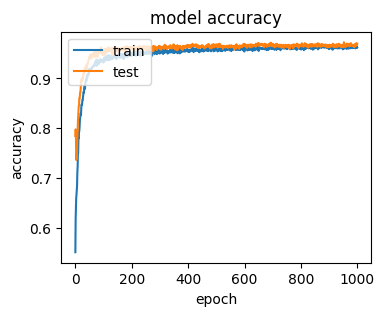

In [53]:
#Testing
score = model.evaluate(test_ds, y_test, batch_size=32)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(his.history.keys())

# summarize history for accuracy
#plt.plot(mo)
fig= plt.figure(figsize=(4,3))
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Export the model

In [54]:
import pathlib
export_dir = 'models/KWS'
model.export(export_dir)

INFO:tensorflow:Assets written to: models/KWS/assets


INFO:tensorflow:Assets written to: models/KWS/assets


Saved artifact at 'models/KWS'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2400), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  130999255730304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130999255736992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130999255738224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130999255914928: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [55]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('models/KWS.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


2024-05-27 13:21:32.193430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:32.193649: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-27 13:21:32.193722: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-27 13:21:32.193937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:32.194096: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-27 13:21:32.302969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:32.303201: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-27 13:21:32.303270: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-27 13:21:32.303535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

27260

### Post-Quantisation

In [56]:
def representative_dataset_gen(num_samples=100):
    for data in train_ds[:num_samples]:
        yield [data.reshape(1, 40, 60, 1)]
##def representative_data_gen():
##    for input_value, _ in y_test.take(100):
##        yield [input_value]
converter_op = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter_op.optimizations = [tf.lite.Optimize.DEFAULT]
converter_op.representative_dataset = representative_dataset_gen
converter_op.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_op.inference_input_type = tf.int8
converter_op.inference_output_type = tf.int8

tflite_model_file = pathlib.Path('models/KWS_op.tflite')
tflite_model_file.write_bytes(converter_op.convert())

INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


2024-05-27 13:21:33.844529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:33.844751: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-27 13:21:33.844821: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-27 13:21:33.845065: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:33.845227: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op', 'serve'}


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables


INFO:tensorflow:Restoring parameters from models/KWS/variables/variables
2024-05-27 13:21:33.959520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 13:21:33.960000: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-27 13:21:33.960071: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-27 13:21:33.960313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05

10472

## Test the accuracy of lite model

In [59]:
## load the dataset again
test_ds = []

for i in melSpec_test_set_yes:
    resized = np.resize(i, (40,60))
    resized = resized.flatten()
    test_ds.append(resized)
for i in melSpec_test_set_no:
    resized = np.resize(i, (40,60))
    resized = resized.flatten()
    test_ds.append(resized)

test_ds = np.array(test_ds)
test_ds = test_ds.astype('float32')

In [60]:
TFLITE_MODEL_FILE = 'models/KWS_op.tflite'
interpreter = tf.lite.Interpreter(model_path = TFLITE_MODEL_FILE)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

test_ds = np.expand_dims(test_ds, axis=1).astype(np.float32)

input_scale, input_zero_point = input_details['quantization']
test_ds = test_ds / input_scale + input_zero_point
test_ds = test_ds.astype(input_details['dtype'])
print(input_scale)
print(input_zero_point)
print(test_ds[3].tolist())

correct_predictions = 0
for i in range(len(test_ds)):
    interpreter.set_tensor(input_details["index"], test_ds[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == y_test[i])
    print(str(i)+': '+str(y_test[i])+' '+str(output)+' '+str(top_prediction))

print('model accuracy is %f%% (Number of test samples=%d)' % (
    (correct_predictions * 100) / len(test_ds), len(test_ds)))


0.3137255012989044
127
[[-46, -14, -14, -33, -6, -8, -5, -20, -6, -27, -16, -10, 8, 4, -15, 0, 10, 0, 2, 4, 2, -32, -23, -14, -5, 6, -7, -17, -15, -16, -24, -33, -18, -25, -36, -23, -30, -24, -28, -43, 32, 26, -8, 6, 2, 4, -5, 7, -13, 0, 4, 5, -18, 2, 8, 6, 9, 15, 7, -11, 1, -9, -14, -17, 2, 6, -18, -28, 2, -8, -21, -12, -23, -45, -38, -25, -27, -15, -28, -39, -11, -8, 21, 22, 24, 2, 22, -12, -8, 13, -6, -17, -2, -8, 6, 12, 2, 2, -3, -7, -17, -5, -9, -2, -17, -29, -22, -16, -17, -10, -11, -17, -14, -37, -23, -27, -26, -29, -48, -33, 52, 55, 59, 59, 52, 34, 41, 31, 2, 7, 10, 4, 2, 1, 3, 10, 23, 28, 25, 36, 11, 2, 13, -8, -1, 1, -14, -23, -17, 1, -10, -2, -9, -8, -8, -11, 3, -6, -17, -32, 8, 53, 52, 27, 23, 23, 6, 18, 3, -18, -6, -17, -26, -1, -11, -17, -3, 18, 3, 0, -17, -29, -12, -27, -15, -28, -23, -12, -22, -16, -28, -27, -21, -17, -34, -20, -20, -21, -24, -22, 10, 61, 60, 12, 11, 23, 0, 19, -14, -5, -2, -26, -26, -33, -26, -7, -1, 12, -16, 2, -18, -32, -11, -12, -6, -2, -1, -20, -9,

In [33]:
import netron
netron.start(R'./models/KWS_op.tflite')

Serving './models/KWS_op.tflite' at http://localhost:8080


('localhost', 8080)

### Create binary file

In [61]:
MODEL_TFLITE = './models/KWS_op.tflite'
MODEL_TFLITE_MICRO = 'kws_yes_no.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [62]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x9c, 0x00, 0x00, 0x00,
  0x24, 0x19, 0x00, 0x00, 0x34, 0x19, 0x00, 0x00, 0x18, 0x28, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x5c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xb8, 0xff, 0xff, 0xff, 0x16, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x43, 0x4f, 0x4e, 0x56, 0x45, 0x52, 0x53, 0x49,
  0x4f, 0x4e, 0x5f, 0x4d, 0x45, 0x54, 0x41, 0x44, 0x41, 0x54, 0x41, 0x00,
  0xdc, 0xff, 0xff, 0xff, 0x15, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x08, 0x